## <h1><center> Projet Méthodes Numériques <h1><center>


**Option pricing when correlations are stochastic: an analytical framework**

BAUBEAU SALAUN Tiburce, EL OUAHABI Taha-Abderrahman,KACEM Khalil

In [ ]:
###############################################################################
################################### Imports ###################################
###############################################################################

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from scipy.linalg import expm, logm, cosm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd
from scipy.linalg import expm, logm, cosm
from scipy.fft import *
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.stats import norm
import plotly.graph_objects as go
import time

In [ ]:
###############################################################################
############################## Class wishart ###############################
###############################################################################

class wishart(object):
  """
    Objective: Calculates option prices under the WASC framework and FFT

    Variables:  - Y (np.array of shape nx1 ): Vector of log spot assets
                - r (float): Risk free IR
                - beta (float): Gindikin coefficient, model parameter
                - M (2-d np.array object of shape nxn): , model parameter
                - Q (2-d np.array object of shape nxn): , model parameter
                - sigma (2-d np.array object of shape nxn): Initial asset covariance matrix. model parameter 
                - rho (2-d np.array object of shape nxn): Matrix of correlation between brownian motions, model parameter 
                - maturity (float): Maturity of the option 

    Methods:    - __init__: Object constructor initializing the pricing environment.
                - create_A_C: Calculates necessary matrices A and c for calclating the characteristic function
                - characteristic_: Calculates the general characteristic function
                - unidimensional_characteristic: Simplifies the characteristic function for the case of options with payoff depanding on one asset (evaluates for asset 1)
                - carr_madan_fft_call_pricer: Returns prices via FFT and Carr-Madan approach 
                - fft_pricer: return the function of interpolation for calculating option prices
  """
  def __init__(self, Y, r, beta, M, Q, sigma, rho, maturity):

    """
      GOAL: Object constructor initializing the trading environment by setting up
            the pricing activity as well as other important variables.

      OUTPUTS: /
    """

    self.dimension = len(M) 
    self.Y = Y
    self.r = r
    self.beta = beta
    self.M = M
    self.Q = Q
    self.sigma = sigma
    self.rho = rho
    self.maturity = maturity 

  def create_A_C(self, Gamma, gamma):

    """
      GOAL: Calculates necessary matrices A and c for calclating the characteristic function

      Inputs:   - Gamma (2-d np.array of shape (nxn)): inputs of the charateristic function
                - gamma (np.array of shape (nx1)): argument of the charateristic function
      
      Outputs:  - the value of objects A,c necessary for calculating the characteristic function

    """
    
    rho_gamma = np.dot(self.rho, np.transpose(gamma))
    bloc1 = self.M + np.dot(np.transpose(self.Q), rho_gamma)

    bloc2 = -2*np.dot(np.transpose(self.Q), self.Q)

    bloc3 = (1/2) * (np.dot(gamma, np.transpose(gamma)) - np.diag(gamma.reshape(self.dimension)))

    bloc4 = -(np.transpose(bloc1)) 

    full_block = self.maturity * np.block([[bloc1, bloc2], [bloc3, bloc4]])

    A_bloc = expm(full_block)


    A_bloc11 = A_bloc[:self.dimension, :self.dimension]
    A_bloc12 = A_bloc[:self.dimension, self.dimension:]
    A_bloc21 = A_bloc[self.dimension:, :self.dimension]
    A_bloc22 = A_bloc[self.dimension:, self.dimension:]

    part_1 = np.linalg.inv(np.dot(Gamma, A_bloc12) + A_bloc22)
    part_2 = np.dot(Gamma, A_bloc11) + A_bloc21

    A = np.dot(part_1, part_2)
    
    c_mat_log = logm(np.dot(Gamma, A_bloc12) + A_bloc22)
    c_mat_T = self.maturity*np.transpose(self.M) + np.dot(self.maturity*gamma, np.dot(np.transpose(self.rho), self.Q))
    
    c_mat =  c_mat_log + c_mat_T

    c = -(self.beta/2)*np.trace(c_mat) + self.maturity*self.r*(gamma.sum()-1)

    return(A, c)
  
  def characteristic_(self, Gamma, gamma):

    """
      GOAL: Calculates the value characteristic function evaluated at t=0, Gamma, gamma under given model parameters

      Inputs:   - Gamma (2-d np.array of shape (nxn)): inputs of the charateristic function
                - gamma (np.array of shape (nx1)): argument of the charateristic function
      
      Outputs:  - the value of the characteristic function at t=0 and arguments Gamma, gamma

    """
    A, c = self.create_A_C(Gamma, gamma)
    
    tr = np.trace(np.dot(A, self.sigma)) + np.dot(np.transpose(gamma), self.Y) + c
    characteristic_fct = np.exp(-self.r*self.maturity)*np.exp(tr)

    return(characteristic_fct[0,0])

  def unidimensional_characteristic(self, gamma):
    """
      GOAL: Returns the value of the marginal characteristic function (unidimensional) of asset 1

      Inputs:   - gamma (complex number): argument of the charateristic function
      
      Outputs:  - the value of the marginal characteristic function at t=0 and arguments gamma

    """

    Gamma = np.zeros((self.dimension, self.dimension))
    vct_gamma = np.array([1j*gamma, 0]).reshape((2,1))
    characteristic_value = self.characteristic_(Gamma, vct_gamma)
    
    return characteristic_value

  def carr_madan_fft_call_pricer(self, N, d_u, alpha, q):

    """
      GOAL: Implementation of Carr Madan approach for calculating vanilla european option price

      Inputs:   - N (integer, preferably a power of 2 ): Number of points to be generated in order for the FFT to be calculated
                - d_u (float): spacing parameter in the frequency domain 
                - alpha (float): damping parameter
                - q (float): stock dividend generation parameter
      Outputs:  - the value of the marginal characteristic function at t=0 and arguments gamma

    """

    d_k = 2 * np.pi / (N * d_u)
    beta = self.Y[0] - d_k * N / 2
    u_arr = np.arange(N) * d_u
    k_arr = beta + np.arange(N) * d_k
    delta_arr = np.zeros(N)
    delta_arr[0] = 1
    w_arr = d_u / 3 * (3 + (-1) ** (np.arange(N) + 1) - delta_arr)
    chf_ln_st_array = np.array([self.unidimensional_characteristic(gamma =elt- (alpha + 1) * 1j) for elt in u_arr])
    call_chf = (np.exp(-self.r * self.maturity) / ((alpha + 1j * u_arr) * (alpha + 1j * u_arr + 1))) * chf_ln_st_array
    x_arr = np.exp(-1j * beta * u_arr) * call_chf * w_arr
    fft_prices = (fft(x_arr))
    call_prices = (np.exp(-alpha * k_arr) / np.pi) * fft_prices.real
    return np.exp(k_arr), call_prices

  def fft_pricer(self, N, d_u, alpha, q, order):
    """
      GOAL: Returns the interpolation function for calculating option prices

      Inputs:   - N (integer, preferably a power of 2 ): Number of points to be generated in order for the FFT to be calculated
                - d_u (float): spacing parameter in the frequency domain 
                - alpha (float): damping parameter
                - q (float): stock dividend generation parameter
                - order (float): Degree of the smoothing spline. Must be between [1, 5]. 5 being the most agressive interpolation
      Outputs:  - the interpolation function whose argument is the strike value

    """
    strike, call_prices = self.carr_madan_fft_call_pricer(N, d_u, alpha, q)
    ffn_pricer = spline_fitting(strike, call_prices, order)

    return(ffn_pricer)


In [ ]:
#########################
### Helper functions ####
#########################

N = norm.cdf

def spline_fitting(x_data, y_data, order):

  """
    GOAL: Interpolates x_data given y_data

    Inputs:   - x_data (np.array): data to be interpolated 
              - y_data (np.array): data to be interpolated to
              - order (float): damping parameter
    Outputs:  - Value of interpolated x_data given y_data and the order of interpolation

  """  
  return InterpolatedUnivariateSpline(x_data, y_data, k=order)

def cd_black_scholes(u, T, r, q,S0, sigma):

  """
    GOAL: Calculates the characteristic function of the log price under the BS dynamics

    Inputs:   - BS model parameters
    Outputs:  - Value of the characteristic function

  """  

  x0 = np.log(S0)     
  inside = 1j * u * x0 + 1j * u * T * (r - (0.5 * (sigma**2))) - 0.5 * T * (u ** 2) * (sigma ** 2)
  return np.exp(inside)

def bs_call(S, K, T, r, sigma):

  """
    GOAL: Calculates the value of BS call

    Inputs:   - BS model parameters
    Outputs:  - Value of the BS call

  """  

  d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
  d2 = d1 - sigma * np.sqrt(T)
  return S * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2)

def bs_vega(S, K, T, r, sigma):

  """
    GOAL: Calculates vega of BS call (necessary for calculating implied vol)

    Inputs:   - BS model parameters
    Outputs:  - Value of the BS vega

  """  

  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
  return S * norm.pdf(d1) * np.sqrt(T)

def find_vol(target_value, S, K, T, r, *args):

  """
    GOAL: Calculates the implied volatility given option price 

    Inputs:   - target_value(float): option price
              - BS model parameters
    Outputs:  - Value of the corresponding BS implied volatility

  """  

  MAX_ITERATIONS = 500
  PRECISION = 1.0e-7
  sigma = 0.5
  for i in range(0, MAX_ITERATIONS):
      price = bs_call(S, K, T, r, sigma)
      vega = bs_vega(S, K, T, r, sigma)
      diff = target_value - price  # our root
      if (abs(diff) < PRECISION):
          return sigma
      sigma = sigma + diff/vega # f(x) / f'(x)
  return sigma # value wasn't found, return best guess so far

def euro_vanilla_call(S, K, T, r, sigma):

  """Returns price of european vanilla call option
    
    Parameters
    ------------
    
    S: Underlying value->float
    K: strike price->float
    T: Time to maturity-> float
    r: Risk free IR->float
    sigma: Vol->positive float
    
    Returns
    -----------
    Price of european vanilla call option->float
    
  """
    
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
  d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
  call = (S * norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * norm.cdf(d2, 0.0, 1.0))
    
  return call

In [ ]:
M = [-2.5, -1.5, -1.5, -2.5]
Q = [0.21, -0.14, 0.14, 0.21]
sigma = [0.09, -0.036, -0.036, 0.09]
rho = np.array([-0.6, -0.6]).reshape((2,1))

M = np.array(M).reshape((2,2))
Q = np.array(Q).reshape((2,2))
sigma = np.array(sigma).reshape((2,2))

r = 0.0
Y = np.array([0, 0]).reshape((2,1))

beta = 7.14286
maturity = 0.2
dimension = 2

N = 2**12
d_u = 0.1
alpha = 2
q = 0

test = wishart(r = r, beta = beta, M = M, Q = Q, sigma = sigma, rho = rho, maturity=maturity, Y=Y)
fft_pricer_ = test.fft_pricer(N, d_u, alpha, q, 2)


In [ ]:
X = np.arange(0.4, 5, 0.05)
Y_WASC = np.array([fft_pricer_(x) for x in X])

Text(0, 0.5, 'Price')

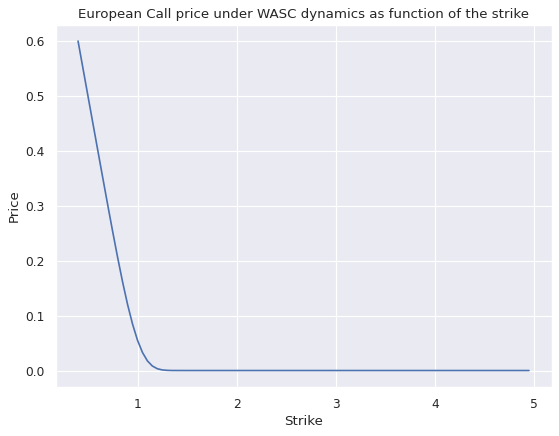

In [ ]:
figure(figsize=(8, 6), dpi=80)

plt.plot(X,Y_WASC)
plt.title('European Call price under WASC dynamics as function of the strike')
plt.xlabel('Strike')
plt.ylabel('Price')

In [ ]:
# Plotting the
K = np.arange(0.7, 1.8, 0.05)
values = fft_pricer_(K)
implied_vol_WASC = [find_vol(values[i], np.exp(0), K[i], maturity, r) for i in range(len(K))]


Text(0, 0.5, 'BS Implied Volatility')

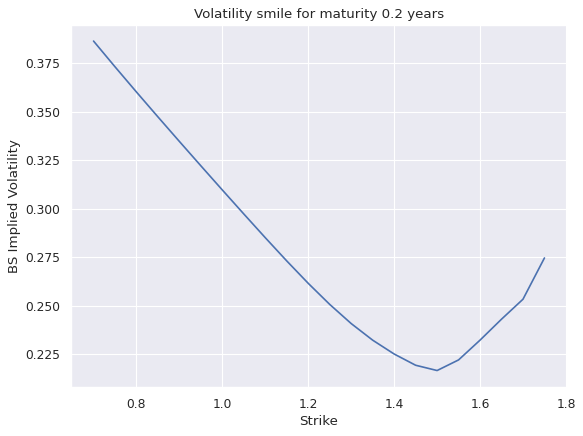

In [ ]:
figure(figsize=(8, 6), dpi=80)

plt.plot(K, implied_vol_WASC)
plt.title('Volatility smile for maturity 0.2 years')
plt.xlabel('Strike')
plt.ylabel('BS Implied Volatility')

In [ ]:
T_array = np.arange(0.2,1.5,0.1)

K = np.arange(0.8, 1.8, 0.05)
vol_values = pd.DataFrame([])

for maturity in T_array:
  
  print(maturity)
  test = wishart(r = r, beta = beta, M = M, Q = Q, sigma = sigma, rho = rho, maturity=maturity, Y=Y)
  fft_pricer_ = test.fft_pricer(N, d_u, alpha, q, 2)
  values = fft_pricer_(K)
  implied_vol_WASC = [find_vol(values[i], np.exp(0), K[i], maturity, r) for i in range(len(K))]
  implied_vol_WASC_df = pd.DataFrame([implied_vol_WASC])
  vol_values = pd.concat([vol_values,implied_vol_WASC_df])

0.2
0.30000000000000004
0.4000000000000001
0.5000000000000001
0.6000000000000001
0.7000000000000002
0.8000000000000003
0.9000000000000001
1.0000000000000002
1.1000000000000003
1.2000000000000004
1.3000000000000003
1.4000000000000004


In [ ]:
vol_values.columns = K
vol_values.index = list(reversed(T_array))
vol_values

,0.80,0.85,0.90,0.95,1.00,1.05,1.10,1.15,1.20,1.25,1.30,1.35,1.40,1.45,1.50,1.55,1.60,1.65,1.70,1.75
1.4,0.360059,0.347189,0.334585,0.321990,0.309543,0.297175,0.284970,0.273083,0.261603,0.250791,0.240971,0.232405,0.225152,0.219072,0.215903,0.221620,0.232139,0.242983,0.253271,0.274542
1.3,0.358565,0.347039,0.335804,0.324734,0.313890,0.303248,0.292849,0.282765,0.273036,0.263775,0.255118,0.247210,0.240136,0.233898,0.228430,0.223594,0.220148,0.219054,0.217087,0.220137
1.2,0.357791,0.347384,0.337294,0.327446,0.317869,0.308545,0.299497,0.290756,0.282337,0.274290,0.266677,0.259562,0.253002,0.247015,0.241559,0.236592,0.232502,0.229200,0.226609,0.223818
1.1,0.357488,0.348022,0.338890,0.330036,0.321471,0.313180,0.305171,0.297455,0.290035,0.282931,0.276171,0.269786,0.263801,0.258230,0.253053,0.248243,0.243997,0.240337,0.237141,0.234120
1.0,0.357485,0.348819,0.340490,0.332456,0.324714,0.317249,0.310061,0.303151,0.296512,0.290152,0.284082,0.278315,0.272863,0.267728,0.262899,0.258357,0.254208,0.250489,0.247140,0.243981
0.9,0.357669,0.349685,0.342037,0.334686,0.327624,0.320835,0.314311,0.308049,0.302038,0.296278,0.290771,0.285521,0.280531,0.275800,0.271317,0.267067,0.263115,0.259485,0.256141,0.252985
0.8,0.357963,0.350567,0.343499,0.336726,0.330234,0.324006,0.318032,0.312302,0.306806,0.301539,0.296498,0.291682,0.287089,0.282716,0.278553,0.274584,0.270854,0.267377,0.264132,0.261047
0.7,0.358316,0.351430,0.344863,0.338584,0.332576,0.326821,0.321308,0.316026,0.310960,0.306105,0.301456,0.297007,0.292756,0.288696,0.284818,0.281110,0.277599,0.274295,0.271182,0.268211
0.6,0.358695,0.352256,0.346125,0.340273,0.334681,0.329331,0.324210,0.319308,0.314608,0.310103,0.305787,0.301654,0.297697,0.293912,0.290287,0.286813,0.283509,0.280378,0.277409,0.274566
0.5,0.359081,0.353034,0.347285,0.341806,0.336575,0.331576,0.326795,0.322219,0.317834,0.313631,0.309602,0.305741,0.302042,0.298497,0.295097,0.291832,0.288717,0.285753,0.282928,0.280216


In [ ]:
z_data = vol_values

z = z_data.values.transpose()
sh_0, sh_1 = z.shape
x, y = T_array, K
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.update_layout(title='Implied Vol surface for the WASC model', autosize=False,
                  width=500, height=500, 
                      scene = dict(
                    xaxis_title='Maturity',
                    yaxis_title='Strike',
                    zaxis_title='Implied Volatility'),
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [ ]:
price_values_corr = []

corr = np.arange(-0.75,0.85,0.1)

N = 2**10
d_u = 0.1
alpha = 2
maturity = 1

for correlation in corr:
  
  print(correlation)
  sigma = [0.09, correlation, correlation, 0.09]
  sigma = np.array(sigma).reshape((2,2))

  test = wishart(r = r, beta = beta, M = M, Q = Q, sigma = sigma, rho = rho, maturity=maturity, Y=Y)
  fft_pricer_ = test.fft_pricer(N, d_u, alpha, q, 2)
  option_price = fft_pricer_(1)
  price_values_corr += [option_price]

-0.75
-0.65
-0.55
-0.45000000000000007
-0.3500000000000001
-0.2500000000000001
-0.15000000000000013
-0.050000000000000155
0.04999999999999982
0.1499999999999998
0.24999999999999978
0.34999999999999964
0.44999999999999973
0.5499999999999998
0.6499999999999997
0.7499999999999996


Text(0, 0.5, 'Price')

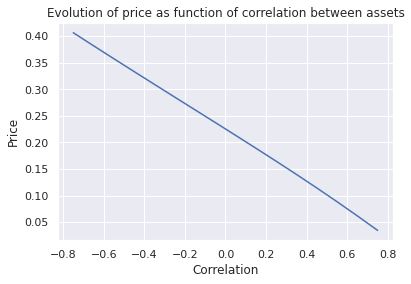

In [ ]:
plt.plot(corr, price_values_corr)
plt.title('Evolution of price as function of correlation between assets')
plt.xlabel('Correlation')
plt.ylabel('Price')

In [ ]:
corr = np.arange(-0.75,0.9,0.15)

price_values_corr_mat = pd.DataFrame([])

for correlation in corr:
  current_corr1 = []
  for correlation2 in corr: 
    rho = np.array([correlation, correlation2]).reshape((2,1))
    test = wishart(r = r, beta = beta, M = M, Q = Q, sigma = sigma, rho = rho, maturity=maturity, Y=Y)
    fft_pricer_ = test.fft_pricer(N, d_u, alpha, q, 2)
    option_price = fft_pricer_(1)
    current_corr1 += [option_price]
  current_corr1 = pd.DataFrame([current_corr1])
  price_values_corr_mat = pd.concat([price_values_corr_mat,current_corr1])

In [ ]:
z_data = price_values_corr_mat

z = z_data.values
x, y = corr, corr
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
fig.update_layout(title=' Asset 1 price as function of Rho', autosize=False,
                  width=500, height=500, 
                      scene = dict(
                    xaxis_title='rho for asset 1',
                    yaxis_title='rho for asset 2',
                    zaxis_title='Price'),
                  margin=dict(l=65, r=50, b=65, t=90))
fig.show()

In [ ]:
from scipy.linalg import sqrtm
import numpy as np
M = [-2.5, -1.5, -1.5, -2.5]
Q = [0.21, -0.14, 0.14, 0.21]
sigma = [0.09, -0.036, -0.036, 0.09]

M = np.array(M).reshape((2,2))
Q = np.array(Q).reshape((2,2))
sigma = np.array(sigma).reshape((2,2))

r = 0
beta = 7.14286
rho = np.array([-0.6, -0.6]).reshape((2,1))
gamma = np.array([-0., -0.]).reshape((2,1))
Gamma = np.zeros((2,2))
S_0=np.array([1,1])
maturity = 0.2


def MC(S_0,r,Sigma_0,maturity,M,beta,rho,Q,n,T):
  dB=np.random.normal(size=(2,n))*np.sqrt(maturity/n)
  dW=np.random.normal(size=(2,2,n))*np.sqrt(maturity/n)
  dZ1=np.sqrt(1-rho[0][0]**2-rho[1][0]**2)*dB[0,:]+rho[0][0]*dW[0,0,:]+rho[1][0]*dW[0,1,:]
  dZ2=np.sqrt(1-rho[0][0]**2-rho[1][0]**2)*dB[1,:]+rho[0][0]*dW[1,0,:]+rho[1][0]*dW[1,1,:]
  dZ=np.array([dZ1,dZ2])
  time=np.linspace(0,T,n)
  S=S_0
  vol=Sigma_0
  for k in range(n):
    sq=sqrtm(vol)
    S=S*(1+r*(T/n)+np.dot(sq,dZ[:,k]))
    vol=vol+(beta*np.dot(np.transpose(Q),Q)+np.dot(M,vol)+np.dot(vol,np.transpose(M)))*(T/n)+np.dot(np.dot(sq,dW[:,:,k]),Q)+np.dot(np.dot(np.transpose(Q),np.transpose(dW[:,:,k])),sq)
  return(S)

n=100
#n2=100000
n2 = 1000
result=[]
for k in range(n2):
  res=MC(S_0,r,sigma,maturity,M,beta,rho,Q,n,maturity)
  if np.all(np.isreal(res)):
    result=result+[res]
result=np.array(result)


Comparing FFT and the MC methods

Text(0, 0.5, 'Price')

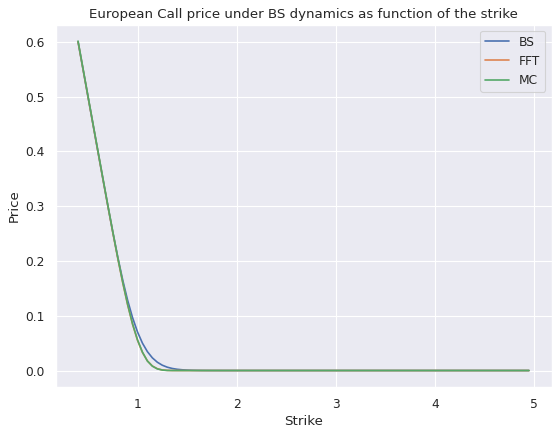

In [ ]:
Y_BS = np.array([euro_vanilla_call(1, x, 0.5, 0, 0.25) for x in X])
Y_MC = np.array([np.mean(np.exp(-r*maturity)*(result[:,0]-strike)*(result[:,0]-strike>0)) for strike in X])

figure(figsize=(8, 6), dpi=80)

plt.plot(X,Y_BS, label='BS')
plt.plot(X,Y_WASC, label='FFT')
plt.plot(X, Y_MC, label ='MC')
plt.title('European Call price under BS dynamics as function of the strike')
plt.xlabel('Strike')
plt.legend(loc="upper right")
plt.ylabel('Price')

In [ ]:
n2 = 1000
maturities = np.array([0.5, 1, 1.5, 2])
strikes = np.arange(0.85, 1.2, 0.05)

N = 2**10
d_u = 0.1
alpha = 2

desc = pd.DataFrame([])
time_dict_MC = {}
time_dict_FFT = {}

for maturity in maturities:
  print(maturity)

  start_MC = time.time()
  result=[]
  for k in range(n2):
    res=MC(S_0,r,sigma,maturity,M,beta,rho,Q,n,maturity)
    if np.all(np.isreal(res)):
      result=result+[res]
  result=np.array(result)
  prices_MC = np.array([np.mean(np.exp(-r*maturity)*(result[:,0]-strike)*(result[:,0]-strike>0)) for strike in strikes])
  end_MC = time.time()
  cpu_time_MC = start_MC - end_MC

  errors_MC = [(1.96/np.sqrt(n2))*np.std(np.exp(-r*maturity)*(result[:,0]-strike)*(result[:,0]-strike>0)) for strike in strikes]
  
  start_FFT = time.time()
  test = wishart(r = r, beta = beta, M = M, Q = Q, sigma = sigma, rho = rho, maturity=maturity, Y=Y)
  fft_pricer__ = test.fft_pricer(N, d_u, alpha, q, 2)
  p_fft = fft_pricer__(strikes)
  end_FFT = time.time()
  cpu_time_FFt = start_FFT - end_FFT

  relative_error = (p_fft - prices_MC)/prices_MC

  desc = pd.concat([desc, pd.DataFrame(prices_MC).rename({0: 'MC_price' + str(maturity)}, axis = 1)], axis = 1)
  desc = pd.concat([desc, pd.DataFrame(p_fft).rename({0: 'FFT_price' + str(maturity)}, axis = 1)], axis = 1)
  desc = pd.concat([desc, pd.DataFrame(errors_MC).rename({0: 'MC_95error' + str(maturity)}, axis = 1)], axis = 1)
  desc = pd.concat([desc, pd.DataFrame(relative_error).rename({0: 'R_error' + str(maturity)}, axis = 1)], axis = 1)

  time_dict_MC[maturity] = cpu_time_MC
  time_dict_FFT[maturity] = cpu_time_FFt

  print(desc)

0.5
   MC_price0.5  FFT_price0.5  MC_95error0.5  R_error0.5
0     0.181755      0.184507       0.011116    0.015138
1     0.146782      0.149174       0.010233    0.016297
2     0.115953      0.117740       0.009247    0.015408
3     0.089046      0.090491       0.008212    0.016218
4     0.066565      0.067550       0.007149    0.014797
5     0.048482      0.048841       0.006093    0.007415
6     0.034277      0.034094       0.005086   -0.005342
1.0
   MC_price0.5  FFT_price0.5  ...  MC_95error1.0  R_error1.0
0     0.181755      0.184507  ...       0.015500    0.036440
1     0.146782      0.149174  ...       0.014557    0.041500
2     0.115953      0.117740  ...       0.013559    0.045833
3     0.089046      0.090491  ...       0.012509    0.046922
4     0.066565      0.067550  ...       0.011467    0.051758
5     0.048482      0.048841  ...       0.010427    0.055918
6     0.034277      0.034094  ...       0.009412    0.059569

[7 rows x 8 columns]
1.5
   MC_price0.5  FFT_price0.5  

In [ ]:
time_dict_MC

{0.5: -16.2539803981781,
 1.0: -15.758509397506714,
 1.5: -15.832106351852417,
 2.0: -15.473958969116211}

In [ ]:
time_dict_FFT

{0.5: -5.228652715682983,
 1.0: -4.971927165985107,
 1.5: -5.113886594772339,
 2.0: -5.126415014266968}

In [ ]:
desc = round(desc,4) 
desc.to_csv('MC_comparaison.csv')